## Extract 3D chromosome contacts to active enhancers in bone marrow CD4+ T cells

Several scATAC-seq papers use for validation the HiChIP data from [Mumbach et al. 2017](https://www.nature.com/articles/ng.3963#Sec1). Here they used [HiChIP](https://www.nature.com/articles/nmeth.3999), a protocol to measure long-range contacts associated with a protein factor of interest, to quantify interactions that happen between regions with H3K27ac, a chromatin modification associated with active enhancers and promoters, to selectively interrogate enhancer–promoter interactions across the genome.  

In this study they profile the following cell types of interest (for bone marrow data):
- Primary naive CD4+ T cells (from patients)
- Negative control for cell-type specific interactions: HCASMC (cell line, muscle cells) 

**Data source:** [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE101498)

## Download datasets

File location: `/nfs/team205/ed6/data/HiChIP_data/`

Download chain file for liftOver

In [ ]:
wget http://hgdownload.soe.ucsc.edu/goldenPath/hg19/liftOver/hg19ToHg38.over.chain.gz

### Process with Juicebox tools

Using [quick start guide](https://github.com/aidenlab/juicer/wiki/Juicer-Tools-Quick-Start) and methods section from [Granja et al.](https://doi.org/10.1038/s41587-019-0332-7).

This converts `.hic` files to sparse matrix format tables (row,col,value) of the interaction signal between any two genomic bins of size 10kb. This script makes one file for each chromosome and sample.

### Read HiChIP data

In [1]:
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import sparse

import pyranges as pr
import pyensembl

In [2]:
import matplotlib
def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

In [3]:
import pyranges as pr

def _pyranges_from_strings(pos_list):
    """
    Function to create pyranges for a `pd.Series` of strings
    (borrowed from SEAcells https://github.com/dpeerlab/SEACells)
    """
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)
                      ).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)
                    ).str.split('-').str.get(1)

    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    return gr


def _pyranges_to_strings(peaks):
    """
    Function to convert pyranges to `pd.Series` of strings of format 'chr:start-end'
    (borrowed from SEAcells https://github.com/dpeerlab/SEACells)
    """
    # Chromosome and positions
    chr = peaks.Chromosome.astype(str).values
    start = peaks.Start.astype(str).values
    end = peaks.End.astype(str).values

    # Create ranges
    gr = chr + ':' + start + '-' + end

    return gr

Here I define helper functions to extract all the interactions measured with a genomic position of interest, or viewpoint. These profiles are referred to as "virtual 4C" in the papers. The interaction is measured as normalized Enhancer Interaction Signal (EIS), which defines the strength of interaction (~ frequency of contact) compared to all other interactions measured. As expected, we always see a strong signal around the view point, and we have to look at lower values to find distal enhancer interactions.

In [4]:
def read_hiChIP(sample):
    data_r1 = np.loadtxt(sample)
    data_r1 = np.asarray(data_r1, dtype = 'int')
    return(data_r1)

def get_virtual4C(
    pos_oi: str, 
    sample: str, 
    data_dir: str = '/nfs/team205/ed6/data/HiChIP_data/',
    bin_size: int = 10000
    ) -> pd.DataFrame:
    '''
    Get signal for contacts around a genomic viewpoint of interest from HiChIP data (virtual 4C profile)
    
    Params
    ------
    pos_oi
        string for position of interest (in the form of chrX:xxxxxx-xxxxxx)
    sample
        name of HiChIP sample to extract the signal from (data is normalized to 1 million)
    data_dir
        string of path to input data 
    bin_size
        window size used for juicer_tools dump (should be 10kb)
        
    Returns
    -------
    Dataframe of contacting genomic position and strength of signal at the position (enhancer interacting score - EIS)
    '''

    pos_gr = _pyranges_from_strings(pd.Series([pos_oi]))

    # Get matching chromosome 
    viewpoint_chr = pos_oi.split(':')[0]

    # Read chromosome files 
    chr_file = read_hiChIP(data_dir + f'{sample}.{viewpoint_chr}.txt')
    
    # Normalize
    norm_eis = (chr_file[:,2]/sum(chr_file[:,2])) * 1000000
    chr_file = np.hstack([chr_file[:,0:2], norm_eis.reshape([-1,1])])

    viewpoints_gr = pr.PyRanges(chromosomes=viewpoint_chr, starts=np.unique(chr_file[:,0]), ends=np.unique(chr_file[:,0]) + bin_size)
    viewpoint = viewpoints_gr.overlap(pos_gr)
#     print(viewpoint)
    viewpoint = viewpoint.as_df()['Start'][0]

    ## Get profile from viewpoint
    signal_df = pd.DataFrame(chr_file[chr_file[:,0] == [viewpoint]][:,1:], columns=['position','EIS'])

    signal_upstream = chr_file[chr_file[:,1] == [viewpoint]][:,[0,2]]
    signal_downstream = chr_file[chr_file[:,0] == [viewpoint]][:,[1,2]]
    signal_df = pd.DataFrame(np.vstack([signal_downstream, signal_upstream]), columns=['position','EIS']).sort_values('position')
    signal_df['viewpoint'] = viewpoint
    signal_df['chromosome'] = viewpoint_chr
    return(signal_df)

In [10]:
data_dir = '/nfs/team205/ed6/data/HiChIP_data/'
[x for x in os.listdir(data_dir) if x.endswith('.hic')]

['Naive_HiChIP_H3K27ac.hic',
 'HCASMC_HiChIP_H3K27ac_G2.hic',
 'Naive_HiChIP_CTCF_B2.hic',
 'Naive_HiChIP_CTCF.hic',
 'GM_HiChIP_H3K27ac_B2.hic',
 'GM_HiChIP_H3K27ac.hic',
 'Naive_HiChIP_CTCF_B1.hic',
 'Naive_HiChIP_H3K27ac_B3.hic',
 'HCASMC_HiChIP_H3K27ac_G1.hic',
 'HCASMC_HiChIP_H3K27ac.hic',
 'GM_HiChIP_H3K27ac_B1.hic',
 'Naive_HiChIP_H3K27ac_B2.hic']

Here we use H3K27ac contacts in naive CD4+T cells (`Naive_HiChIP_H3K27ac`) and in the muscle cell line as negative control (`HCASMC_HiChIP_H3K27ac`)

## Get signal for genes / cell types of interest

In [131]:
# # Get all gene ranges from Ensembl (but this is for hg38)
# from pyensembl import EnsemblRelease
# def ens_genes2df(genes):
#     '''
#     Convert pyemsembl genes to feature 
#     dataframe readable by muon
#     '''
#     genes_df = pd.DataFrame()
#     genes_df['Chromosome'] = ["chr" + x.contig for x in genes]
#     genes_df['Start'] = [x.start for x in genes]
#     genes_df['End'] = [x.end for x in genes]
#     genes_df['GeneName'] = [x.gene_name for x in genes]
#     genes_df['GeneID'] = [x.gene_id for x in genes]
#     return(genes_df)

# data = EnsemblRelease(77)
# gene_names = data.genes()
# genes_df = ens_genes2df(gene_names)

In [11]:
def plot_virtual4C_gene_locus(signal_gene_df, ymax=100):
    '''
    Visualization of locus and enhancer
    '''
    fig,axs = plt.subplots(nrows=2, ncols=1, height_ratios=(1,10))
    
    gene_name = signal_gene_df['gene_name'].tolist()[0]
    coords = f"{signal_gene_df['chromosome'].tolist()[0]}:{signal_gene_df['position'].min()}-{signal_gene_df['position'].max()}"
        
    # plot gene coords
    gene_gr = _pyranges_from_strings(pd.Series(signal_gene_df['gene_coords'][0])).as_df()
    axs[0].plot([gene_gr['Start'][0], gene_gr['End'][0]],[gene_name,gene_name], color='blue', linewidth=10); ## vertical
    axs[0].set_xlim(signal_gene_df.position.min(),signal_gene_df.position.max());
    remove_x_axis(axs[0])
    axs[0].set_title(coords);
    
    # Plot signal
    for _,s in enumerate(signal_gene_df['sample_name'].unique()):
        signal_df = signal_gene_df[signal_gene_df['sample_name'] == s]
        axs[1].plot(signal_df.position, signal_df.EIS, label=s);

    # plot viewpoint coordinates
    axs[1].axvline(x=signal_df.viewpoint.values[0], color='r', linewidth=1, linestyle='--'); ## vertical
    axs[1].axvline(x=signal_df.viewpoint.values[0] + 10000, color='r', linewidth=1, linestyle='--'); ## vertical
    plt.ylabel("Enhancer interaction signal");
    plt.ylim(0,ymax);
    plt.xlabel('Genomic coordinate');
    plt.legend()

Define genomic coordinates for genes with validated enhancers in T cells.

In [1]:
# Manually searched for these coords in gene cards (hg19)
genes_oi_coords = {
    'CLEC16A':'chr16:11038421-11276043',
    'CD69':'chr12:9905082-9913497',
    'ID2':'chr2:8822186-8824591'
}

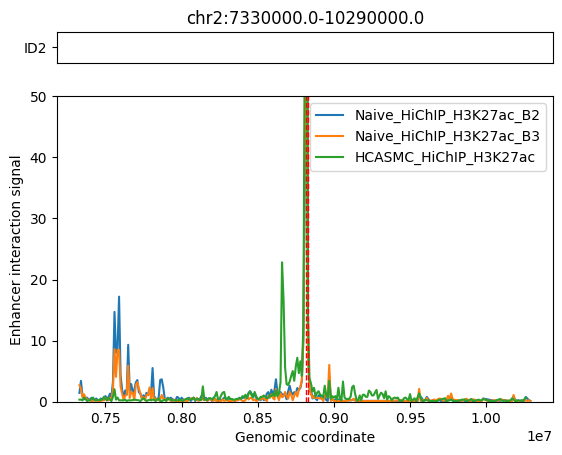

In [16]:
window_size = 1500000
gene_name = 'ID2'
pos_oi = genes_oi_coords[gene_name]

samples = ['Naive_HiChIP_H3K27ac_B2', 'Naive_HiChIP_H3K27ac_B3'] + ['HCASMC_HiChIP_H3K27ac']

signal_gene_df = pd.DataFrame()
for sample_name in samples:
    signal_df = get_virtual4C(pos_oi, sample_name)
    signal_df = signal_df[np.abs(signal_df['position'] - signal_df['viewpoint']) < window_size]
    signal_df['gene_name'] = gene_name
    signal_df['sample_name'] = sample_name
    signal_df['gene_coords'] = pos_oi
    signal_gene_df = pd.concat([signal_gene_df, signal_df])
    
plot_virtual4C_gene_locus(signal_gene_df, ymax=50)
# signal_gene_df.to_csv(data_dir + f"EIS_signal_{gene_name}promoter.csv")

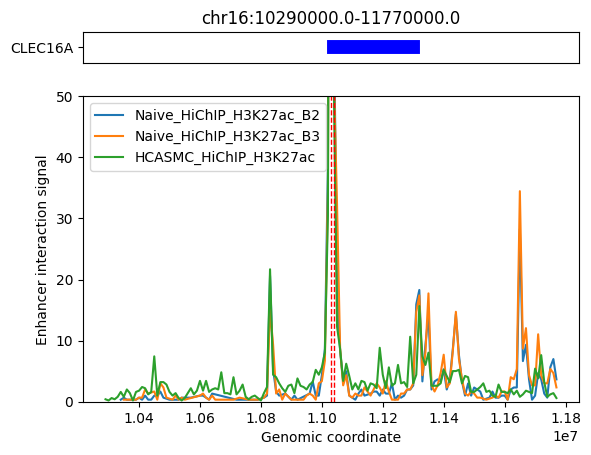

In [138]:
window_size = 750000
gene_name = 'CLEC16A'

pos_oi = genes_oi_coords[gene_name]

samples = ['Naive_HiChIP_H3K27ac_B2', 'Naive_HiChIP_H3K27ac_B3'] + ['HCASMC_HiChIP_H3K27ac']

signal_gene_df = pd.DataFrame()
for sample_name in samples:
    signal_df = get_virtual4C(pos_oi, sample_name)
    signal_df = signal_df[np.abs(signal_df['position'] - signal_df['viewpoint']) < window_size]
    signal_df['gene_name'] = gene_name
    signal_df['sample_name'] = sample_name
    signal_df['gene_coords'] = pos_oi
    signal_gene_df = pd.concat([signal_gene_df, signal_df])
    
plot_virtual4C_gene_locus(signal_gene_df, ymax=50)
signal_gene_df.to_csv(data_dir + f"EIS_signal_{gene_name}promoter.csv")

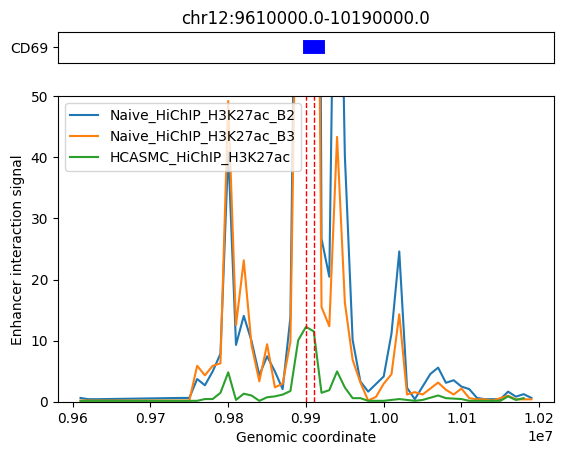

In [139]:
window_size = 300000
gene_name = 'CD69'

pos_oi = genes_oi_coords[gene_name]

samples = ['Naive_HiChIP_H3K27ac_B2', 'Naive_HiChIP_H3K27ac_B3'] + ['HCASMC_HiChIP_H3K27ac']

signal_gene_df = pd.DataFrame()
for sample_name in samples:
    signal_df = get_virtual4C(pos_oi, sample_name)
    signal_df = signal_df[np.abs(signal_df['position'] - signal_df['viewpoint']) < window_size]
    signal_df['gene_name'] = gene_name
    signal_df['sample_name'] = sample_name
    signal_df['gene_coords'] = pos_oi
    signal_gene_df = pd.concat([signal_gene_df, signal_df])
    
plot_virtual4C_gene_locus(signal_gene_df, ymax=50)
signal_gene_df.to_csv(data_dir + f"EIS_signal_{gene_name}promoter.csv")

In [18]:
signal_gene_df

,position,EIS,viewpoint,chromosome,gene_name,sample_name,gene_coords
729,9610000,0,9900000,chr12,CD69,Naive_HiChIP_H3K27ac_B2,chr12:9905082-9913497
730,9620000,0,9900000,chr12,CD69,Naive_HiChIP_H3K27ac_B2,chr12:9905082-9913497
731,9630000,0,9900000,chr12,CD69,Naive_HiChIP_H3K27ac_B2,chr12:9905082-9913497
732,9740000,0,9900000,chr12,CD69,Naive_HiChIP_H3K27ac_B2,chr12:9905082-9913497
733,9750000,0,9900000,chr12,CD69,Naive_HiChIP_H3K27ac_B2,chr12:9905082-9913497
...,...,...,...,...,...,...,...
24,10140000,0,9900000,chr12,CD69,Naive_HiChIP_H3K27ac_B3,chr12:9905082-9913497
25,10150000,0,9900000,chr12,CD69,Naive_HiChIP_H3K27ac_B3,chr12:9905082-9913497
26,10160000,0,9900000,chr12,CD69,Naive_HiChIP_H3K27ac_B3,chr12:9905082-9913497
27,10170000,0,9900000,chr12,CD69,Naive_HiChIP_H3K27ac_B3,chr12:9905082-9913497


Here:

- position: indicates the genomic coordinates of the locus in contact with the viewpoint locus
- EIS: stores the interaction signal (normalized)
- viewpoint: indicates the genomic coordinates of the viewpoint. Here the viewpoint always matches the promoter/TSS of a given gene
- gene_name: the name of the gene of which the promoter is the viewpoint
- sample_name: HiChIP sample for which the interaction was measured (sample name indicates the cell type/line and the biological replicate e.g. B1)
- gene_coords: string of coordinates of the gene body, for plotting

## Convert to hg38

In [21]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /usr/lib/R
INFO:rpy2.situation:R library path: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/lib/R/lib:/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-8-openjdk-amd64/jre/lib/amd64/server
INFO:rpy2.situation:LD_LIBRARY_PATH: /usr/lib/R/lib:/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-8-openjdk-amd64/jre/lib/amd64/server
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save


In [22]:
%load_ext rpy2.ipython

INFO:rpy2.rinterface_lib.embedded:R is already initialized. No need to initialize.


In [23]:
%%R
# BiocManager::install("rtracklayer")
library(rtracklayer)
library(GenomicRanges)
library(tidyverse)

# Load chain file for liftover from hg19 to hg38
chain <- import.chain("/nfs/team205/ed6/data/HiChIP_data/hg19ToHg38.over.chain")

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [26]:
%%R -i data_dir

lift_position <- function(chr, start, end){
    viewpoint_df <- data.frame(chr=chr, start = start, end = end)
    viewpoint_gr <- makeGRangesFromDataFrame(viewpoint_df)
    viewpoint_gr_lifted <- unlist(liftOver(viewpoint_gr, chain))
    out_df <- data.frame(viewpoint_gr_lifted)[,c('seqnames', 'start', 'end')] %>%
     dplyr::rename(chr = seqnames)
    return(out_df)
    }

lift_virtual_4C <- function(EIS_file){
    df <- read.csv(EIS_file)

    # Lift viewpoint
    viewpoint_df <- data.frame(chr=df$chromosome[1], start = df$viewpoint[1], end = df$viewpoint[1] + 10000)
    viewpoint_gr <- makeGRangesFromDataFrame(viewpoint_df)
    viewpoint_gr_lifted <- unlist(liftOver(viewpoint_gr, chain))

    # Lift contact points
    position_df <- data.frame(chr=df$chromosome, start = df$position, end = df$position + 10000)
    position_gr <- makeGRangesFromDataFrame(position_df)
    grl <- liftOver(position_gr, chain)
    position_gr_lifted <- unlist(GRangesList(lapply(grl, function(gr) GenomicRanges::reduce(gr, min.gapwidth=10))))

    # Lift gene coords
    gene_coords <- stringr::str_split(df$gene_coords[1], ':')[[1]]
    gene_coords_df <- data.frame(chr=gene_coords[1], start=stringr::str_split(gene_coords[2], '-')[[1]][1], end=stringr::str_split(gene_coords[2], '-')[[1]][2])
    gene_coords_gr <- makeGRangesFromDataFrame(gene_coords_df)
    gene_coords_gr_lifted <- unlist(liftOver(gene_coords_gr, chain))
    gene_coords_df_lifted <- data.frame(gene_coords_gr_lifted)
    gene_coords_lifted <- do.call(paste0, list(gene_coords_df_lifted[1, 1], ':', gene_coords_df_lifted[1, 2], "-", gene_coords_df_lifted[1, 3]))

    # Store lifted version
    df_hg38 <- df %>% dplyr::select( - X)
    df_hg38[,'position'] <- data.frame(position_gr_lifted)$start
    df_hg38[,'viewpoint'] <- data.frame(viewpoint_gr_lifted)$start
    df_hg38[,'gene_coords'] <- gene_coords_lifted
    write.csv(df_hg38, stringr::str_replace(EIS_file, '.csv', '.hg38.csv'))
    }

# data_dir <- '/nfs/team205/ed6/data/HiChIP_data/'
# for (f in list.files(data_dir, pattern='promoter.csv')){
#     lift_virtual_4C( paste0(data_dir, f) )
# }
lift_virtual_4C( paste0(data_dir, 'EIS_signal_CD19promoter.csv') )

In [52]:
data_dir + f"EIS_signal_{gene_name}promoter.hg38.csv"

'/nfs/team205/ed6/data/HiChIP_data/EIS_signal_CD19promoter.hg38.csv'

In [50]:
gene_name = 'CD19'
signal_gene_df = pd.read_csv(data_dir + f"EIS_signal_{gene_name}promoter.hg38.csv")
signal_gene_df = signal_gene_df.drop('Unnamed: 0', 1)
signal_gene_df

/tmp/ipykernel_6087/1165162652.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  signal_gene_df = signal_gene_df.drop('Unnamed: 0', 1)


,position,EIS,viewpoint,chromosome,gene_name,sample_name,gene_coords
0,28468679,0.606187,28928679,chr16,CD19,GM_HiChIP_H3K27ac_B1,chr16:28931971-28939342
1,28478679,1.414436,28928679,chr16,CD19,GM_HiChIP_H3K27ac_B1,chr16:28931971-28939342
2,28488679,4.849495,28928679,chr16,CD19,GM_HiChIP_H3K27ac_B1,chr16:28931971-28939342
3,28498679,2.020623,28928679,chr16,CD19,GM_HiChIP_H3K27ac_B1,chr16:28931971-28939342
4,28508679,0.606187,28928679,chr16,CD19,GM_HiChIP_H3K27ac_B1,chr16:28931971-28939342
...,...,...,...,...,...,...,...
238,29348679,2.007396,28928679,chr16,CD19,HCASMC_HiChIP_H3K27ac,chr16:28931971-28939342
239,29358679,0.602219,28928679,chr16,CD19,HCASMC_HiChIP_H3K27ac,chr16:28931971-28939342
240,29398679,0.200740,28928679,chr16,CD19,HCASMC_HiChIP_H3K27ac,chr16:28931971-28939342
241,29408679,0.200740,28928679,chr16,CD19,HCASMC_HiChIP_H3K27ac,chr16:28931971-28939342
